In [2]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
import healpy as hp
from tqdm import tqdm
import torch
import torch.nn as nn

from scipy.stats import chi2
from scipy.stats import norm

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *
from theory.limit import get_lim

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/var/folders/d8/fkpry78n5tz_ztp9lvhv88fm0000gn/T/ipykernel_1387/519798695.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [3]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5


## Basline analysis

In [7]:
import sbi.utils as utils
import mlflow

run_id = 'f00c10126eac4c31a6ccc9ec4836df27'
    
data_dir = '/scratch/sm8383/neural-global-astrometry/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model(data_dir + '/logs/mlruns/2/' + run_id + '/artifacts/density_estimator')

In [8]:
Sigma_q = 1e8 / (4 * np.pi)
pixarea = hp.nside2pixarea(nside=64, degrees=False)
N_q_pix = Sigma_q * pixarea

In [9]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [10]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.sigma != 0.:
            sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
            x = x + sampled_noise
        return x 

In [11]:
device = 'cuda'

In [15]:
x_test = [torch.Tensor(np.load("../../sbi-astrometry/data/samples/x_test_150_{}.npy".format(i))) for i in range(5)]
x_test = torch.cat(x_test, axis=0)
gn = GaussianNoise(sigma=0.0023)
x_test = gn(x_test)

n_trials = x_test.shape[0]  # Number of samples to simulate
n_test = 100  # Number of points in f_sub over which to compute likelihood ratio

out = np.zeros((n_trials, n_test))

theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

for i in tqdm(range(n_test)):
    out[:, i] = density_estimator.to(device)(x_test.to(device), theta_test[i].repeat(n_trials).unsqueeze(1).to(device)).to('cpu').detach().numpy()[:, 0] 
    

100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


In [16]:
out_mean = np.mean(out, axis=0)

In [5]:
plt.rcParams.update({"text.usetex": False})

In [14]:
plt.plot(theta_test[:, 0], out_mean)
plt.axvline(150)

NameError: name 'theta_test' is not defined

## Coverage

In [15]:
from theory.limit import get_interval
from scipy.interpolate import interp1d

In [47]:
p_ary = np.linspace(0.05, 0.95, 100)
theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

n_mc = 10
n_each_mc = 10
n_test = 100  # Number of points in f_sub over which to compute likelihood ratio

empirical_cov = np.zeros((n_mc, len(p_ary)))

for i_mc in range(n_mc):
    
    #########
    
    x_test = [torch.Tensor(np.load("../../sbi-astrometry/data/samples/x_test_{}.npy".format(i))) for i in range(i_mc * n_each_mc, (i_mc + 1) * n_each_mc)]
    x_test = torch.cat(x_test, axis=0)

    theta_calib_test = [torch.Tensor(np.load("../../sbi-astrometry/data/samples/theta_test_{}.npy".format(i))) for i in range(i_mc * n_each_mc, (i_mc + 1) * n_each_mc)]
    theta_calib_test = torch.cat(theta_calib_test, axis=0)

    x_test = x_test[(100 < theta_calib_test[:, 0]) * (theta_calib_test[:, 0] < 200)]
    theta_calib_test = theta_calib_test[(100 < theta_calib_test[:, 0]) * (theta_calib_test[:, 0] < 200)]

    gn = GaussianNoise(sigma=0.0023)
    x_test = gn(x_test)

    n_trials = x_test.shape[0]  # Number of samples to simulate

    out = np.zeros((n_trials, n_test))

    

    for i in tqdm(range(n_test)):
        out[:, i] = density_estimator.to(device)(x_test.to(device), theta_test[i].repeat(n_trials).unsqueeze(1).to(device)).to('cpu').detach().numpy()[:, 0] 

    #########

    llr = - 2 * out
    llr.shape
    llr -= np.min(llr, axis=0)
    llrmin, llrmax = 0., 30.
    llr = np.clip(llr, llrmin, llrmax)

    theta_interp = np.linspace(1., 300, 1000)
    llr_interp = interp1d(theta_test.squeeze().numpy(), llr, axis=-1)(theta_interp)

    

    coverage_matrix_nancount = np.zeros((n_trials, len(p_ary)))
    coverage_matrix = np.zeros((n_trials, len(p_ary)))
    
    for i in tqdm(range(n_trials)):
        for j, p in enumerate(p_ary):
            try:
                lo, hi = get_interval(np.expand_dims(llr_interp[i], 0), theta_interp, p=p)
                if lo < theta_calib_test.squeeze().numpy()[i] < hi:
                    coverage_matrix[i, j] += 1
            except:
                coverage_matrix_nancount[i, j] += 1
                pass

    empirical_cov[i_mc, :] = coverage_matrix.sum(axis=0) / (n_trials - coverage_matrix_nancount.sum(axis=0))
    
    

100%|██████████| 304/304 [00:15<00:00, 19.38it/s]


In [51]:
# np.save("../data/plot_arrays/p_ary.npy", p_ary)
# np.save("../data/plot_arrays/empirical_cov.npy", empirical_cov)

In [4]:
p_ary = np.load("../data/plot_arrays/p_ary.npy")
empirical_cov = np.load("../data/plot_arrays/empirical_cov.npy")

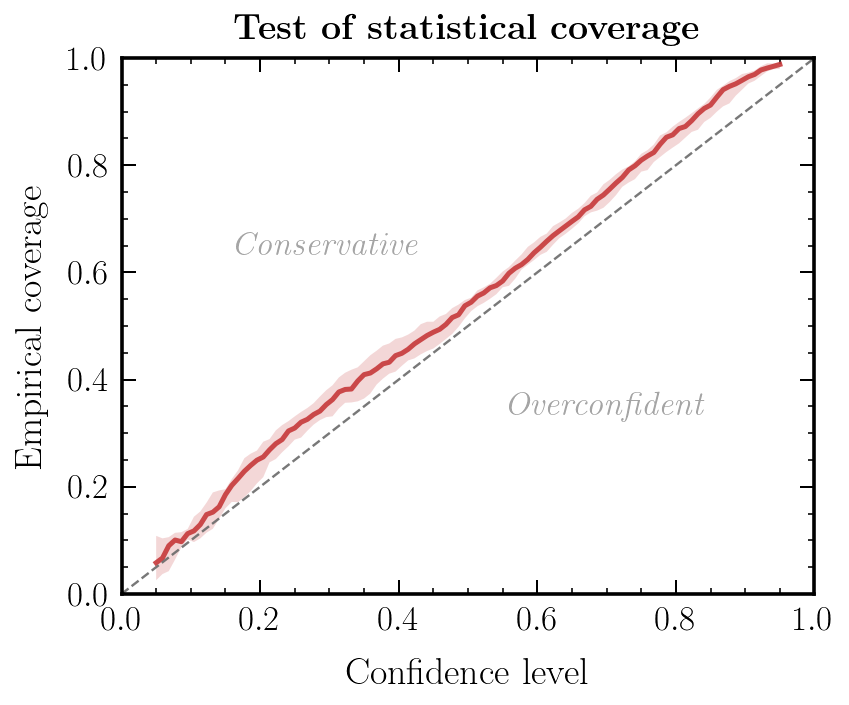

In [41]:
plt.figure(figsize=(6, 5))

plt.plot(p_ary, np.median(empirical_cov, axis=0))
plt.fill_between(p_ary, np.percentile(empirical_cov, [16], axis=0)[0], np.percentile(empirical_cov, [84], axis=0)[0], alpha=0.2)
plt.plot([0,1],[0,1], label="Perfect calibration", color='dimgrey', ls='--', lw=1.2)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Confidence level")
plt.ylabel("Empirical coverage")
plt.title(r"\bf{Test of statistical coverage}", y=1.008)
# plt.legend(loc='upper left', frameon=True, framealpha=0.9, handlelength=1.2, fontsize=16)

def get_aspect(ax=None):
    if ax is None:
        ax = plt.gca()
    fig = ax.figure

    ll, ur = ax.get_position() * fig.get_size_inches()
    width, height = ur - ll
    axes_ratio = height / width
    aspect = axes_ratio / ax.get_data_ratio()

    return aspect

plt.text(0.3, 0.65, r"\emph{Conservative}",  ha='center', va='center', color='dimgrey', alpha=0.6, fontsize=17)
plt.text(0.7, 0.35, r"\emph{Overconfident}",ha='center', va='center', color='dimgrey', alpha=0.6, fontsize=17)

plt.tight_layout()
plt.savefig("../paper/journal-response-v1/coverage.pdf")